## Youtube Sentimental Analysis

Sentiment analysis is the process of analyzing text to determine its emotional tone—whether it's positive, negative, or neutral. This technique is widely used in areas like customer feedback analysis, social media monitoring, and brand sentiment evaluation.

In this project we'll analys youtube comment 

### Import python libraries

In [1]:
# You can also use this section to suppress warnings generated by your code:

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

import tensorflow as tf
from tensorflow import keras
from keras.utils import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.preprocessing.text import one_hot
from keras import initializers
from tensorflow.keras.layers import SimpleRNN, Dense,Bidirectional, Embedding,BatchNormalization,LSTM, GRU, Conv1D, Dropout
from tensorflow.keras.optimizers import Adam

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
2025-09-18 18:46:32.681767: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758221192.878100      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758221192.933651      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Help Functions

In [3]:
# function to compute the accuracy, precision, recall and F1 score of a model's predictions.
def calculate_results(y_true, y_pred):
    model_accuracy = accuracy_score(y_true, y_pred)
    model_precision, model_recall, model_f1,_ = precision_recall_fscore_support(y_true, y_pred,average="weighted")
    model_results = {"accuracy":model_accuracy,
                     "precision":model_precision,
                     "recall" :model_recall,
                     "f1":model_f1}
    return model_results

# Load the dataset

In [4]:
df = pd.read_csv("/kaggle/input/youtube-comments-dataset/YoutubeCommentsDataSet.csv")

In [5]:
df.head(10)

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive
5,we’ve been hounding my bank to adopt apple pay...,neutral
6,we only got apple pay in south africa in 20202...,positive
7,for now i need both apple pay and the physical...,neutral
8,in the united states we have an abundance of r...,positive
9,in cambodia we have a universal qr code system...,neutral


### Data Cleaning & Transformation

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18408 entries, 0 to 18407
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Comment    18364 non-null  object
 1   Sentiment  18408 non-null  object
dtypes: object(2)
memory usage: 287.8+ KB


### *Dealing with null values in the dataframe*

In [7]:
print(f'The total missing values in per column: {df.isna().sum()}')
df.dropna(inplace=True)

The total missing values in per column: Comment      44
Sentiment     0
dtype: int64


The are 44 null values in the data frame to be remove from comment column

### *Dealing with duplicate values in the data frame*

In [8]:
print(f'The total number of duplicated value in the data frame: {df.duplicated().sum()}')
df.drop_duplicates(inplace=True)

The total number of duplicated value in the data frame: 490


There are 490 Duplicates that's been deleted from the dataframe

The shape of the `dataFrame`

In [9]:
print(f'The total number of entry column: {df.shape[0]}')

print(f'The total number of entry featues: {df.shape[1]}')

The total number of entry column: 17874
The total number of entry featues: 2


## Exploratory data analyst(EDA)

Let's check the sentiment column distribution, which is the target column for this project

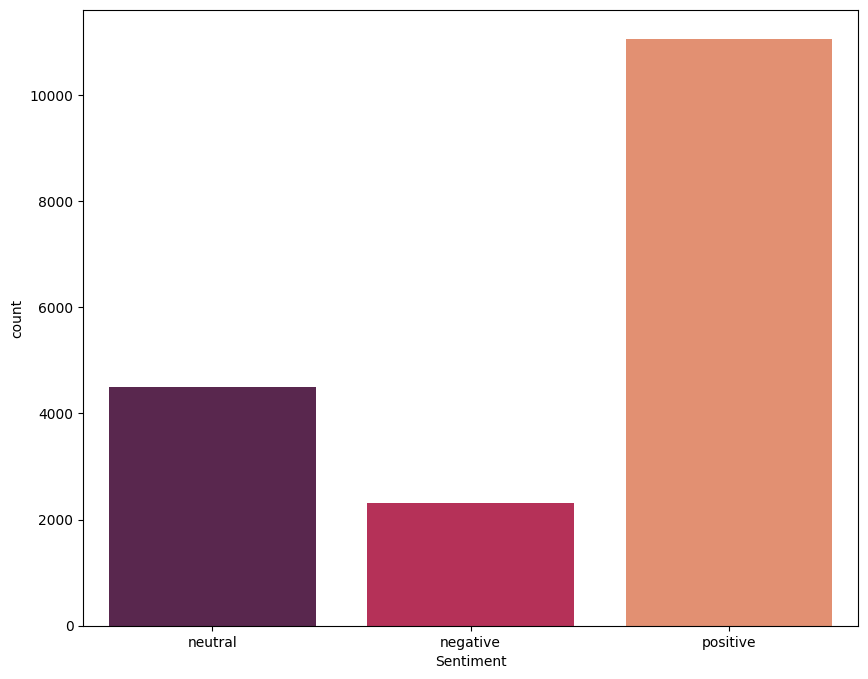

In [10]:
plt.figure(figsize=(10,8))
sns.countplot(data=df, x="Sentiment", palette='rocket')
plt.show()

Insight: TIn the sentiment column we have postive 61.8%, neutral 25.1% and negative sentiment 12.9%, the column is not well distributed.  

### Features Engineer Techniques

In [11]:
import re
from collections import Counter
from nltk.tokenize import sent_tokenize

# Ensure 'Comment' column exists and handle NaN
df['Comment'] = df['Comment'].astype(str)

# Word list (basic split)
df['word_list'] = df['Comment'].apply(lambda x: x.split())

# Sentence count using regex (., !, ? as sentence terminators)
#df['sentence_count'] = df['Comment'].apply(lambda x: len(re.findall(r'[.!?]', x)))

# Word count from the word list
df['word_count'] = df['word_list'].apply(len)

# Flatten word list and count frequencies
word_counts = Counter([word for sublist in df['word_list'] for word in sublist])

df.drop(['word_list'], axis=1, inplace=True)
# Top 20 common words as DataFrame
temp = pd.DataFrame(word_counts.most_common(20), columns=['Common_words', 'count'])

# Display with styling (works best in Jupyter)
styled_temp = temp.style.background_gradient(cmap='Blues')

styled_temp

,Common_words,count
0,the,22269
1,to,14707
2,and,14213
3,i,13292
4,a,12924
5,of,9428
6,you,8049
7,is,7890
8,in,7566
9,this,7065


In [12]:
df['word_count'].describe()

count    17874.000000
mean        32.991664
std         45.526381
min          1.000000
25%         12.000000
50%         21.000000
75%         38.000000
max       1353.000000
Name: word_count, dtype: float64

### Most Common words in our Target-Selected Text

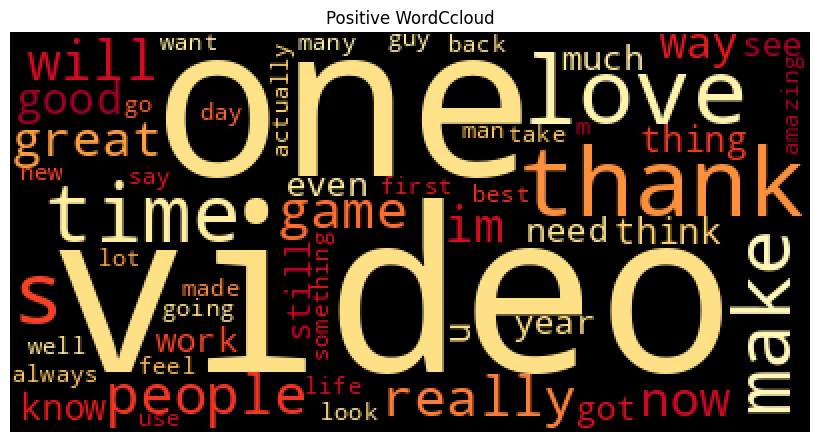

In [13]:
# Download stopwords

from wordcloud import STOPWORDS

# Define stopwords
stop_words = set(STOPWORDS)

# Convert comments to a list, filter stopwords, and join
def preprocess_comments(comment_series):
    return ' '.join(
        word for comment in comment_series.dropna().tolist()
        for word in comment.split() if word.lower() not in stop_words
    )

# Process comments
pos_text = preprocess_comments(df["Comment"])

# Generate WordClouds
wordcloud_pos = WordCloud(width=400, height=200, background_color='black',
                          stopwords=stop_words, colormap='YlOrRd', max_words=200,
                          min_font_size=10).generate(pos_text)


# Plot WordClouds
plt.figure(figsize=(8, 6), facecolor=None)
plt.title('Positive WordCcloud')
plt.imshow(wordcloud_pos)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()



# Text processing in comment column

# Train test_split

In [14]:
df["Sentiment"][:5]

0     neutral
1    negative
2    positive
3    negative
4    positive
Name: Sentiment, dtype: object

In [15]:
df[df['Sentiment'] == 'positive']['Comment'].values[0]

'i will forever acknowledge this channel with the help of your lessons and ideas explanations now its quite helpful while youll just sit at your comfort and monitor your account growth'

In [16]:
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer

def wordopt(Comment):
    Comment = re.sub('\[.*?\]', '', Comment)
    Comment = re.sub('https?://\S+|www\.\S+', '', Comment)
    Comment = re.sub('[%s]' % re.escape(string.punctuation), '', Comment)
    Comment = re.sub('\n', '', Comment)
    Comment = re.sub('\w*\d\w*', '', Comment)
    return Comment

# Assuming df is already defined and has a "Comment" column
df["Clean_Comment"] = df["Comment"].apply(wordopt)

#Fit the Vectorizer feature
# One-hot encoding
vocab_size = 10000
one_hot_pre = [one_hot(text, vocab_size) for text in df["Clean_Comment"]]

# Padding sequences
sent_length = 500  # 5000 is very long; 500 is more typical
embedded_docs = pad_sequences(one_hot_pre, padding='pre', maxlen=sent_length)

print(embedded_docs)


[[   0    0    0 ... 1431 7552 8712]
 [   0    0    0 ... 6063 9787 5740]
 [   0    0    0 ...  639 7056 2383]
 ...
 [   0    0    0 ... 8087 6566 5378]
 [   0    0    0 ... 1017 4561 6444]
 [   0    0    0 ... 5415  880 1540]]


In [17]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()


df["Sentiment"] = df["Sentiment"].replace({ "positive": 0,"neutral": 1, "negative":2})
yv = df["Sentiment"]


X = np.array(embedded_docs)
y = np.array(yv)
y

array([1, 2, 0, ..., 1, 0, 0])

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123,stratify = y)

## Machine Learning Model Buliding 

In [19]:
# Hyperparameters
max_features = 10000 
maxlen = 5000

In terms of pre-processing, we pad sequences to the same length using `pad_sequences`. Sequences longer than `num_timesteps` are truncated so that they fit the desired length. Whereas sequences that are shorter than `num_timesteps` are padded with value until they are `num_timesteps` long.


In [20]:
# data preprocessing
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)


y_train = tf.keras.utils.to_categorical(y_train, 3)
y_test = tf.keras.utils.to_categorical(y_test, 3)

X_train shape: (14299, 5000)
X_test shape: (3575, 5000)


## 1.RNN

## Earlystopping

Stops training when performance stops improving.

In [21]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

In [22]:
## Let's build a RNN

rnn_hidden_dim = 5
word_embedding_dim = 1000
model_rnn = Sequential()
model_rnn.add(Embedding(max_features, word_embedding_dim))  #This layer takes each integer in the sequence and embeds it in a 50-dimensional vector
model_rnn.add(SimpleRNN(rnn_hidden_dim,
                    kernel_initializer=initializers.RandomNormal(stddev=0.001),
                    recurrent_initializer=initializers.Identity(gain=1.0),
                    activation='relu',
                    input_shape=X_train.shape[1:]))

model_rnn.add(Dense(3, activation='softmax'))

I0000 00:00:1758221209.585695      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


### Model summary

### Train the RNN model

In [23]:
from tensorflow.keras.optimizers import Adam
model_rnn.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

#fit the model ann
model_rnn.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stop,reduce_lr])


Epoch 1/20


I0000 00:00:1758221213.032916      63 service.cc:148] XLA service 0x7a00e02b4e20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758221213.033442      63 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758221213.393182      63 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1758221214.507296      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


224/224 ━━━━━━━━━━━━━━━━━━━━ 154s 666ms/step - accuracy: 0.5801 - loss: 141.0333 - val_accuracy: 0.6274 - val_loss: 0.7414 - learning_rate: 0.0010
Epoch 2/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 147s 658ms/step - accuracy: 0.6537 - loss: 0.6617 - val_accuracy: 0.6783 - val_loss: 0.6897 - learning_rate: 0.0010
Epoch 3/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 147s 657ms/step - accuracy: 0.7383 - loss: 0.5732 - val_accuracy: 0.6915 - val_loss: 0.6997 - learning_rate: 0.0010
Epoch 4/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 147s 658ms/step - accuracy: 0.7779 - loss: 0.4988 - val_accuracy: 0.6965 - val_loss: 0.7388 - learning_rate: 0.0010
Epoch 5/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 147s 657ms/step - accuracy: 0.8318 - loss: 0.4224 - val_accuracy: 0.6962 - val_loss: 0.7627 - learning_rate: 2.0000e-04


### RNN model evaluation

In [24]:

from sklearn.metrics import classification_report

y_train_preds = model_rnn.predict(X_train)
y_train_labels = (y_train_preds > 0.5).astype(int)  # for binary classification
print('Classification evaluation')
print(classification_report(y_train, y_train_labels))

print('The loss and Accuracy evaluation')
loss, accuracy = model_rnn.evaluate(X_train, y_train)
print(f'Train accuracy: {accuracy * 100:.2f}%')
print(f'Train loss: {loss * 100:.2f}')

447/447 ━━━━━━━━━━━━━━━━━━━━ 116s 259ms/step
Classification evaluation
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      8843
           1       0.86      0.23      0.36      3602
           2       0.00      0.00      0.00      1854

   micro avg       0.88      0.61      0.72     14299
   macro avg       0.58      0.37      0.41     14299
weighted avg       0.76      0.61      0.64     14299
 samples avg       0.61      0.61      0.61     14299

The loss and Accuracy evaluation
447/447 ━━━━━━━━━━━━━━━━━━━━ 117s 261ms/step - accuracy: 0.7275 - loss: 0.5934
Train accuracy: 73.49%
Train loss: 58.07


## 2. GRU

In [25]:
# Write your solution here
embedding_vector_features = 1000

model = Sequential()
model.add(Embedding(max_features, embedding_vector_features,input_length= (X_train.shape[1:])))
model.add(GRU(128, dropout=0.2))
model.add(Dense(3, activation='softmax'))

In [26]:
# Write your solution here
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10,batch_size=64, validation_data=(X_test, y_test),verbose=2, callbacks=[early_stop,reduce_lr])
model.evaluate(X_test,y_test)

Epoch 1/10
224/224 - 113s - 506ms/step - accuracy: 0.6099 - loss: 0.8931 - val_accuracy: 0.6406 - val_loss: 0.7800 - learning_rate: 1.0000e-04
Epoch 2/10
224/224 - 108s - 481ms/step - accuracy: 0.6973 - loss: 0.6829 - val_accuracy: 0.7018 - val_loss: 0.6669 - learning_rate: 1.0000e-04
Epoch 3/10
224/224 - 108s - 481ms/step - accuracy: 0.7542 - loss: 0.5810 - val_accuracy: 0.7041 - val_loss: 0.6534 - learning_rate: 1.0000e-04
Epoch 4/10
224/224 - 108s - 481ms/step - accuracy: 0.8062 - loss: 0.4948 - val_accuracy: 0.7057 - val_loss: 0.6594 - learning_rate: 1.0000e-04
Epoch 5/10
224/224 - 108s - 481ms/step - accuracy: 0.8386 - loss: 0.4206 - val_accuracy: 0.7158 - val_loss: 0.7136 - learning_rate: 1.0000e-04
Epoch 6/10
224/224 - 108s - 481ms/step - accuracy: 0.8672 - loss: 0.3591 - val_accuracy: 0.7069 - val_loss: 0.7662 - learning_rate: 1.0000e-04
112/112 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - accuracy: 0.7002 - loss: 0.6526


[0.6495370268821716, 0.707132875919342]

### Evaluetion GRU Model

#### Calculate the cross entropy of each value

In [27]:
# Get predicted probabilities
pred_probs = model.predict(X_test)

# Compute loss
loss = tf.keras.losses.categorical_crossentropy(y_test, pred_probs)

# Convert to numpy and print mean loss
print("Loss:", tf.reduce_mean(loss).numpy())

112/112 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step
Loss: 0.651209


In [28]:
from sklearn.metrics import classification_report

y_train_preds = model.predict(X_train)
y_train_labels = (y_train_preds > 0.5).astype(int)  # for binary classification
print('Classification evaluation')
print(classification_report(y_train, y_train_labels))

print('The loss and Accuracy evaluation')
loss, accuracy = model.evaluate(X_train, y_train)
print(f'Train accuracy: {accuracy * 100:.2f}%')
print(f'Train loss: {loss * 100:.2f}%')

447/447 ━━━━━━━━━━━━━━━━━━━━ 60s 135ms/step
Classification evaluation
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      8843
           1       0.79      0.52      0.63      3602
           2       0.85      0.13      0.22      1854

   micro avg       0.89      0.69      0.78     14299
   macro avg       0.85      0.51      0.58     14299
weighted avg       0.88      0.69      0.74     14299
 samples avg       0.69      0.69      0.69     14299

The loss and Accuracy evaluation
447/447 ━━━━━━━━━━━━━━━━━━━━ 62s 138ms/step - accuracy: 0.8037 - loss: 0.5082
Train accuracy: 80.96%
Train loss: 50.15%


## 3. LSTM Model

In [29]:
embedding_vector_features = 1000
model3 = Sequential()
model3.add(Embedding(max_features, embedding_vector_features, input_length=X_train.shape[1]))
model3.add(Bidirectional(LSTM(100)))
model3.add(Dropout(0.4))
model3.add(BatchNormalization())
model3.add(Dense(3, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#fit the model
model3.fit(X_train, y_train, epochs=20,batch_size=64, validation_data=(X_test, y_test),verbose=2, callbacks=[early_stop,reduce_lr])

Epoch 1/20
224/224 - 223s - 995ms/step - accuracy: 0.6159 - loss: 0.8708 - val_accuracy: 0.6386 - val_loss: 0.7407 - learning_rate: 0.0010
Epoch 2/20
224/224 - 218s - 973ms/step - accuracy: 0.8115 - loss: 0.4802 - val_accuracy: 0.7015 - val_loss: 0.6782 - learning_rate: 0.0010
Epoch 3/20
224/224 - 218s - 973ms/step - accuracy: 0.8824 - loss: 0.3118 - val_accuracy: 0.7152 - val_loss: 0.8707 - learning_rate: 0.0010
Epoch 4/20
224/224 - 218s - 973ms/step - accuracy: 0.9284 - loss: 0.1981 - val_accuracy: 0.6987 - val_loss: 1.1614 - learning_rate: 0.0010
Epoch 5/20
224/224 - 218s - 973ms/step - accuracy: 0.9715 - loss: 0.0952 - val_accuracy: 0.6990 - val_loss: 1.1466 - learning_rate: 2.0000e-04


In [30]:
y_train_preds = model3.predict(X_train)
y_train_labels = (y_train_preds > 0.5).astype(int)  # for binary classification
print('Classification evaluation')
print(classification_report(y_train, y_train_labels))

print('The loss and Accuracy evaluation')
loss, accuracy = model3.evaluate(X_train, y_train)
print(f'Train accuracy: {accuracy * 100:.2f}%')
print(f'Train loss: {loss * 100:.2f}')

447/447 ━━━━━━━━━━━━━━━━━━━━ 130s 290ms/step
Classification evaluation
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      8843
           1       0.92      0.80      0.86      3602
           2       0.98      0.44      0.61      1854

   micro avg       0.94      0.84      0.89     14299
   macro avg       0.95      0.73      0.80     14299
weighted avg       0.94      0.84      0.88     14299
 samples avg       0.84      0.84      0.84     14299

The loss and Accuracy evaluation
447/447 ━━━━━━━━━━━━━━━━━━━━ 130s 292ms/step - accuracy: 0.8989 - loss: 0.3528
Train accuracy: 90.13%
Train loss: 34.93


112/112 ━━━━━━━━━━━━━━━━━━━━ 32s 289ms/step


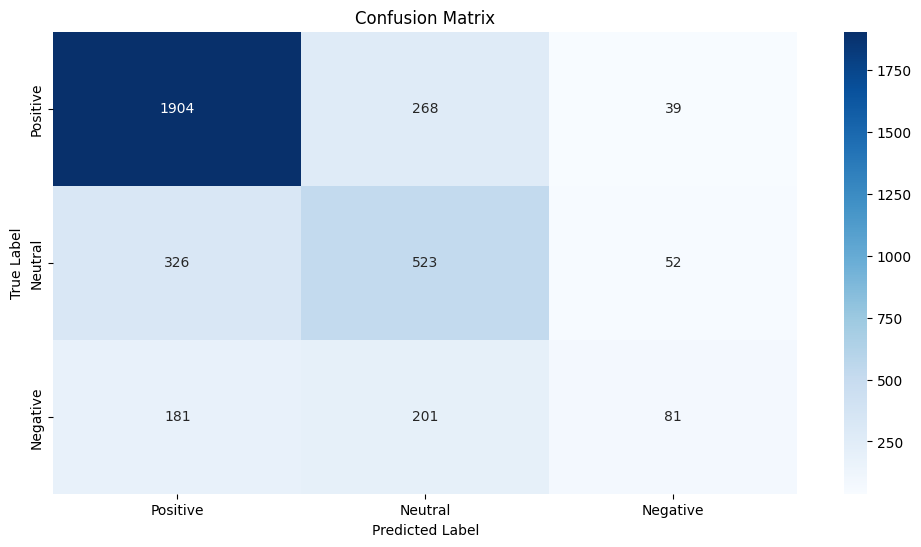

In [31]:
from sklearn.metrics import confusion_matrix

# Get predicted and true labels
predictions = model3.predict(X_test)
predictions = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Define class labels
classes = {0: 'Positive', 1: 'Neutral', 2: 'Negative'}

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot
plt.figure(figsize=(12,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=list(classes.values()),
            yticklabels=list(classes.values()),
            cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Model evaluation

224/224 ━━━━━━━━━━━━━━━━━━━━ 60s 268ms/step - accuracy: 0.7277 - loss: 0.5933
224/224 ━━━━━━━━━━━━━━━━━━━━ 38s 170ms/step - accuracy: 0.8047 - loss: 0.5092
224/224 ━━━━━━━━━━━━━━━━━━━━ 85s 379ms/step - accuracy: 0.8990 - loss: 0.3527


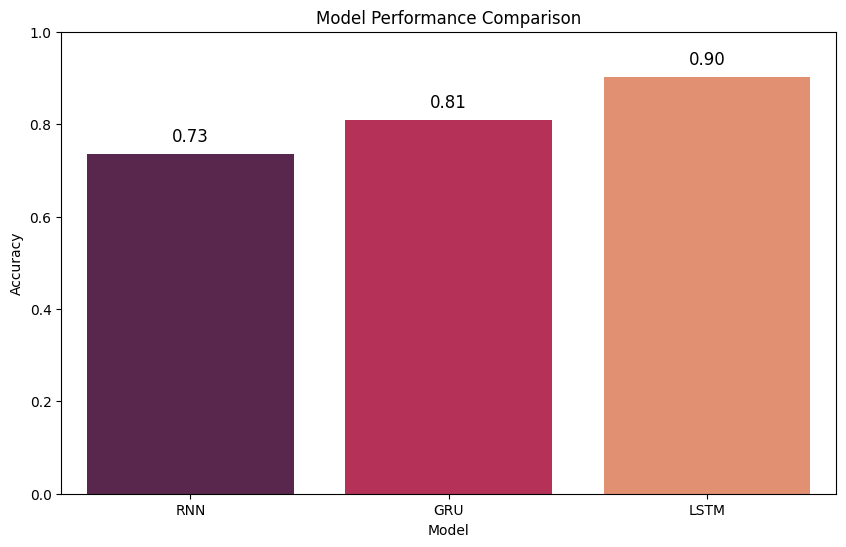

In [32]:
# Model names and their corresponding accuracies
model_names = ['RNN', 'GRU', 'LSTM']
accuracies = [
    model_rnn.evaluate(X_train, y_train, batch_size=64)[1],  # RNN
    model.evaluate(X_train, y_train, batch_size=64)[1],    # GRU
    model3.evaluate(X_train, y_train, batch_size=64)[1]    # LSTM
]

# Plotting the accuracies
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=model_names, y=accuracies, palette='rocket')  # Assign to ax
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)

# Add value labels
for i, acc in enumerate(accuracies):
    ax.text(i, acc + 0.02, f'{acc:.2f}', ha='center', va='bottom', fontsize=12)

plt.show()


## Transform  model - context Based Language model or LLM

In [33]:
from transformers import pipeline
from datasets import load_dataset

In [34]:
Classification = pipeline("text-classification")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cuda:0


In [35]:
df['Comment'][100]

'the monitor looks pretty average size until marques reaches his whole extended arm towards it and points out the 27” screen size and suddenly you realize… it’s a 55” monitor '

In [36]:
Classification(df['Comment'][100])

[{'label': 'NEGATIVE', 'score': 0.5056216716766357}]

In [37]:
df['Comment'][2500]

'i was losing my confidence in thinking my dream of opening up a local coffee shop would be impossible but this story was so inspiring mooney is so damn down to earth its really cool to see the success of just the love and passion into it'

In [38]:
Classification(df['Comment'][2500])

[{'label': 'POSITIVE', 'score': 0.9997493624687195}]

In [39]:
review = "That Salah goal vs city has to be one of the best goals not just because of how good it is. Its against one of the best teams in Europe and one of the best defence while being in a title race. Most of his goals are against big 6 just shows he always turns up in big games. What a player he is."
review


'That Salah goal vs city has to be one of the best goals not just because of how good it is. Its against one of the best teams in Europe and one of the best defence while being in a title race. Most of his goals are against big 6 just shows he always turns up in big games. What a player he is.'

In [40]:
Classification(review)

[{'label': 'POSITIVE', 'score': 0.999664306640625}]